## 07. Reproduce the 2022 paper
**26 March 2025 by MiniUFO**

---
[TOC]

---
### 1. Introduction
Here we reproduce results from several papers on relative dispersion which used synthetic drifter datasets.  The first one is the four measures with analytical expressions, relative dispersion, kurtosis, relative diffusivity, and CIST, demonstrated in [LaCasce and Meunier (2022)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/relative-dispersion-with-finite-inertial-ranges/A4810AD4971C9C9FC920CE4BDAF8AE95).

---

### 2. Calculation
#### 2.1 load the synthetic drifter dataset in a $K^{-3}$ turbulence

In [1]:
import numpy as np
import xarray as xr
import warnings
import sys
warnings.filterwarnings("ignore")
sys.path.append('../../../')
from xdispersion import RelativeDispersion

drifters = xr.open_dataset('../../../data/Particles_nonlocal.nc')

rd = RelativeDispersion(drifters, ragged=False, ID='ID',
                        xpos='xpos', uvel='uvel', time='time',
                        ypos='ypos', vvel='vvel', coord='cartesian')

pairs = rd.get_all_pairs()
pairs_ori = rd.get_original_pairs(pairs, r0=[0, 0.01])
pairs_ori

<xarray.Dataset>
Dimensions:   (pair: 2920, particle: 2)
Coordinates:
  * pair      (pair) int32 0 104 2103 3997 ... 1998979 1998990 1998997 1998999
  * particle  (particle) int32 0 1
Data variables:
    tlen      (pair) float32 2e+03 2e+03 2e+03 2e+03 ... 2e+03 2e+03 2e+03 2e+03
    stime     (pair) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    r0        (pair) float32 0.01 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01 0.01
    pID       (pair, particle) float32 0.0 1.0 0.0 ... 1.998e+03 1.999e+03
    xpos0     (pair, particle) float32 3.042 3.042 3.042 ... 3.232 3.232 3.232
    ypos0     (pair, particle) float32 3.042 3.052 3.042 ... 3.072 3.072 3.082

#### 2.2 Calculate all separation-based measures
All the separation-based measures can be calculated by a single call as:

In [13]:
from xdispersion import gen_rbins, rel_disp, rel_diff, kurtosis, cumul_inv_sep_time

alpha = 1.2
rbins = gen_rbins(0.01, 20, alpha)

# get all building blocks for the four measures
rx, ry, rxy, r = rd.separation_measures(pairs_ori)

r2   = rel_disp(r, order=2, mean_at='const-t')
K2   = rel_diff(r, mean_at='const-t')
Ku   = kurtosis(r, mean_at='const-t')
CIST = cumul_inv_sep_time(r, rbins=rbins, lower=0.07, upper=0.93,
                          maskout=[1e-8, 5e3], mean_at='const-r')

#### 2.3 Plot the four measures

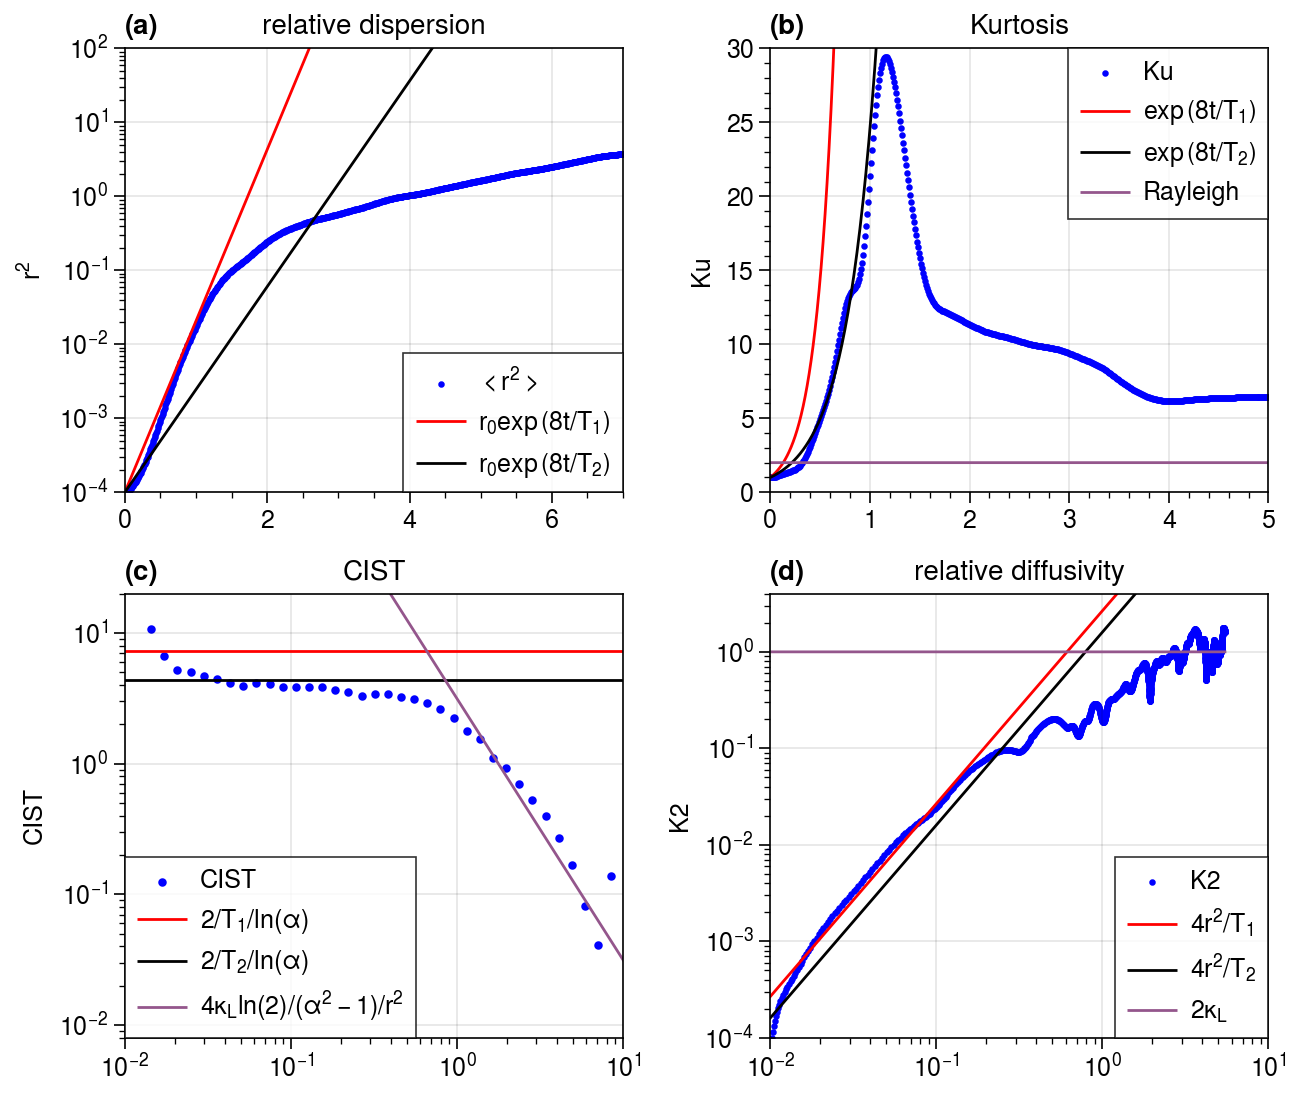

In [16]:
import proplot as pplt
from xdispersion import panel, ana_r2, ana_Ku, ana_CIST, ana_K2

params1 = {'T':1.5, 'beta':0.5, 'k2':0.5, 'r0':0.01}
params2 = {'T':2.5, 'beta':0.5, 'k2':0.5, 'r0':0.01}

rtmp = np.sqrt(r2)

r2_Lund1 = ana_r2(rtmp, params1, 'Lundgren')
r2_Lund2 = ana_r2(rtmp, params2, 'Lundgren')
Ku_Lund1 = ana_Ku(rtmp, params1, 'Lundgren')
Ku_Lund2 = ana_Ku(rtmp, params2, 'Lundgren')
Ku_rayl1 = ana_Ku(rtmp, params1, 'Rayleigh')
CI_Lund1 = ana_CIST(rbins, alpha, params1, 'Lundgren')
CI_Lund2 = ana_CIST(rbins, alpha, params2, 'Lundgren')
CI_rayl1 = ana_CIST(rbins, alpha, params1, 'Rayleigh-a')
K2_Lund1 = ana_K2(rtmp, params1, 'Lundgren')
K2_Lund2 = ana_K2(rtmp, params2, 'Lundgren')
K2_rayl1 = ana_K2(rtmp, params1, 'Rayleigh')

v1  = {'var':r2, 'r':rtmp, 'method':'scatter', 'label':'$<r^2>$', 's':3, 'color':'blue'}
v11 = {'var':r2_Lund1, 'r':rtmp, 'method':'plot', 'label':'$r_0\\exp\\left(8t/T_1\\right)$', 'lw':1, 'color':'r'}
v12 = {'var':r2_Lund2, 'r':rtmp, 'method':'plot', 'label':'$r_0\\exp\\left(8t/T_2\\right)$', 'lw':1, 'color':'k'}
v2  = {'var':Ku, 'r':rtmp, 'method':'scatter', 'label':'Ku', 's':3, 'color':'blue'}
v21 = {'var':Ku_Lund1, 'r':rtmp, 'method':'plot', 'label':'$\\exp\\left(8t/T_1\\right)$', 'lw':1, 'color':'r'}
v22 = {'var':Ku_Lund2, 'r':rtmp, 'method':'plot', 'label':'$\\exp\\left(8t/T_2\\right)$', 'lw':1, 'color':'k'}
v23 = {'var':Ku_rayl1, 'r':rtmp, 'method':'plot', 'label':'Rayleigh', 'lw':1, 'color':'purple'}
v3  = {'var':CIST, 'r':rbins, 'method':'scatter', 'label':'CIST', 's':6, 'color':'blue'}
v31 = {'var':CI_Lund1 , 'r':rbins, 'method':'plot', 'label':'$2/T_1/ln(\\alpha)$', 'lw':1, 'color':'r'}
v32 = {'var':CI_Lund2 , 'r':rbins, 'method':'plot', 'label':'$2/T_2/ln(\\alpha)$', 'lw':1, 'color':'k'}
v33 = {'var':CI_rayl1 , 'r':rbins, 'method':'plot', 'label':'$4\\kappa_L ln(2)/(\\alpha^2-1)/r^2$', 'lw':1, 'color':'purple'}
v4  = {'var':K2, 'r':rtmp, 'method':'scatter', 'label':'K2', 's':3, 'color':'blue'}
v41 = {'var':K2_Lund1, 'r':rtmp, 'method':'plot', 'label':'$4r^2/T_1$', 'lw':1, 'color':'r'}
v42 = {'var':K2_Lund2, 'r':rtmp, 'method':'plot', 'label':'$4r^2/T_2$', 'lw':1, 'color':'k'}
v43 = {'var':K2_rayl1, 'r':rtmp, 'method':'plot', 'label':'$2\\kappa_L$', 'lw':1, 'color':'purple'}

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(6.5, 5.5), facecolor='w',
                          sharex=0, sharey=0)

ax = panel(axes[0,0], [v1],[v11,v12], title='relative dispersion', timebased=True,
           yscale='log', xscale='linear', ylim=[1e-4, 1e2], xlim=[0, 7], fontsize=10,
           ylabel='$r^2$', loc='lr', ncols=1)
ax = panel(axes[0,1], [v2],[v21,v22,v23], title='Kurtosis', timebased=True,
           yscale='linear', xscale='linear', ylim=[0, 30], xlim=[0, 5], fontsize=10,
           ylabel='Ku', loc='ur', ncols=1)
ax = panel(axes[1,0], [v3],[v31,v32,v33], title='CIST', timebased=False,
           yscale='log', xscale='log', ylim=[8e-3, 2e1], xlim=[1e-2, 1e1], fontsize=10,
           ylabel='CIST', loc='ll', ncols=1)
ax = panel(axes[1,1], [v4],[v41,v42,v43], title='relative diffusivity', timebased=False,
           yscale='log', xscale='log', ylim=[1e-4, 4e0], xlim=[1e-2, 10], fontsize=10,
           ylabel='K2', loc='lr', ncols=1)

axes.format(abc='(a)')

---

### 3. Calculation
#### 3.1 load the synthetic drifter dataset in a $K^{-5/3}$ turbulence

In [18]:
drifters = xr.open_dataset('../../../data/Particles_local.nc')

rd = RelativeDispersion(drifters, ragged=False, ID='ID',
                        xpos='xpos', uvel='uvel', time='time',
                        ypos='ypos', vvel='vvel', coord='cartesian')

pairs = rd.get_all_pairs()
pairs_ori = rd.get_original_pairs(pairs, r0=[0, 0.01])
pairs_ori

<xarray.Dataset>
Dimensions:   (pair: 2920, particle: 2)
Coordinates:
  * pair      (pair) int32 0 104 2103 3997 ... 1998979 1998990 1998997 1998999
  * particle  (particle) int32 0 1
Data variables:
    tlen      (pair) float32 2e+03 2e+03 2e+03 2e+03 ... 2e+03 2e+03 2e+03 2e+03
    stime     (pair) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    r0        (pair) float32 0.01 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01 0.01
    pID       (pair, particle) float32 0.0 1.0 0.0 ... 1.998e+03 1.999e+03
    xpos0     (pair, particle) float32 3.042 3.042 3.042 ... 3.232 3.232 3.232
    ypos0     (pair, particle) float32 3.042 3.052 3.042 ... 3.072 3.072 3.082

#### 3.2 Calculate all separation-based measures
All the separation-based measures can be calculated by a single call as:

In [42]:
from xdispersion import gen_rbins, rel_disp, rel_diff, kurtosis, cumul_inv_sep_time

alpha = 1.2
rbins = gen_rbins(0.01, 20, alpha)

# get all building blocks for the four measures
rx, ry, rxy, r = rd.separation_measures(pairs_ori)

r2   = rel_disp(r, order=2, mean_at='const-t')
K2   = rel_diff(r, mean_at='const-t')
Ku   = kurtosis(r, mean_at='const-t')
CIST = cumul_inv_sep_time(r, rbins=rbins, lower=0.1, upper=0.9,
                          maskout=[1e-8, 5e3], mean_at='const-r')

#### 3.3 Plot the four measures

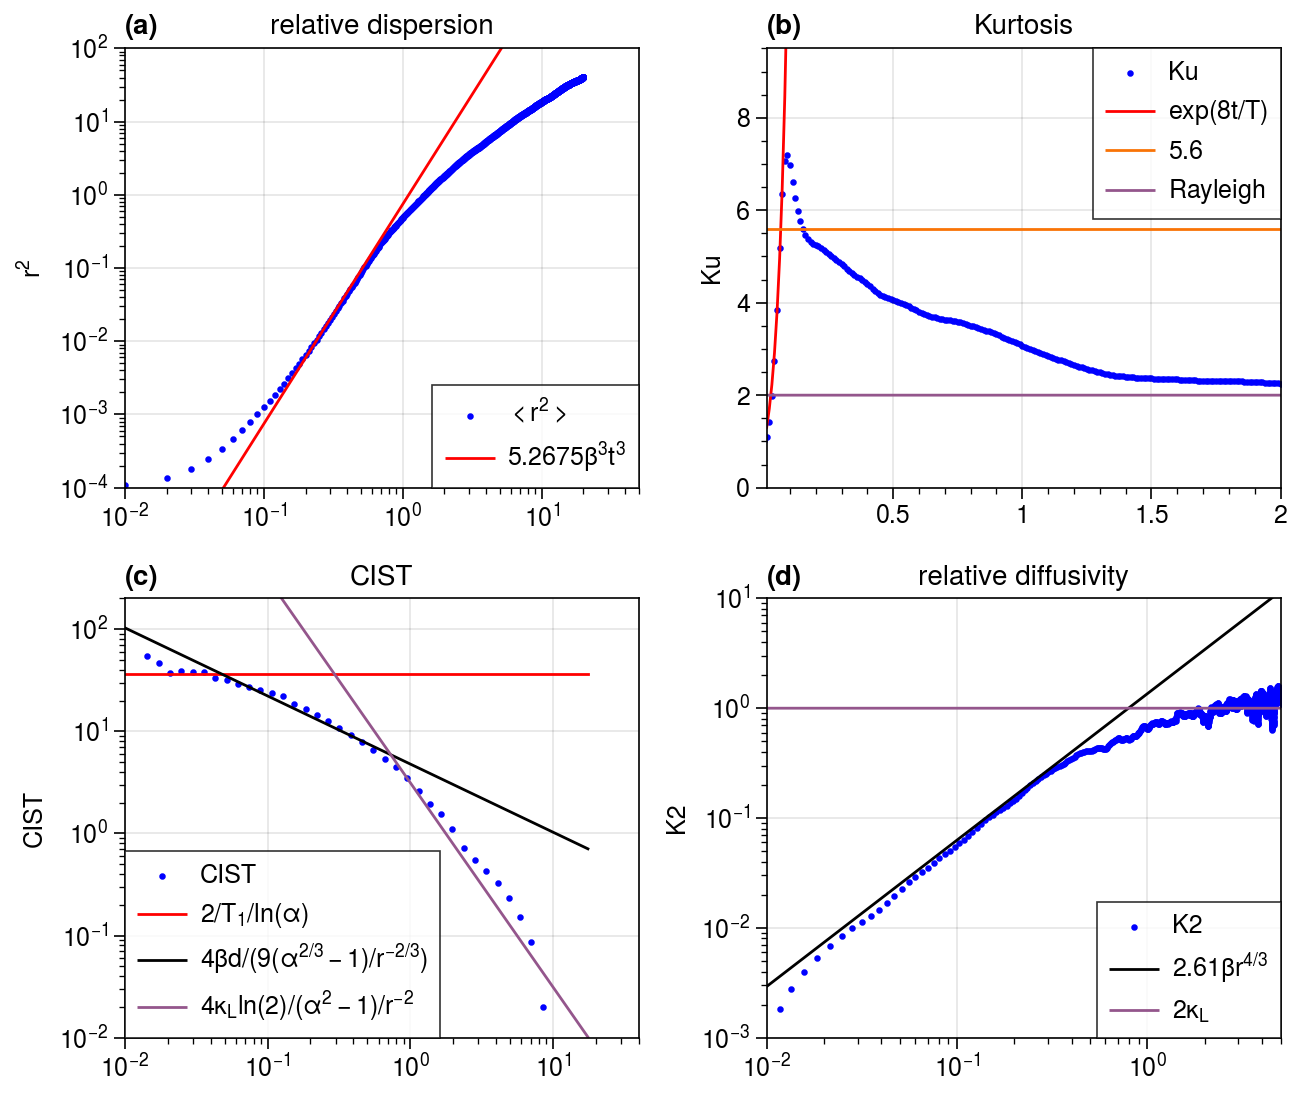

In [44]:
import proplot as pplt
from xdispersion import panel, ana_r2, ana_Ku, ana_CIST, ana_K2

params1 = {'T':0.3, 'beta':0.52, 'k2':0.5, 'r0':0.01}

rtmp = np.sqrt(r2)

r2_lund1 = ana_r2(rtmp, params1, 'Lundgren')
r2_rich1 = ana_r2(rtmp, params1, 'Richardson-a')
Ku_rich1 = ana_Ku(rtmp, params1, 'Lundgren')
Ku_rich2 = ana_Ku(rtmp, params1, 'Richardson-a')
Ku_rich3 = ana_Ku(rtmp, params1, 'Rayleigh')
CIST_rich1 = ana_CIST(rbins, alpha, params1, 'Lundgren')
CIST_rich2 = ana_CIST(rbins, alpha, params1, 'Richardson-a')
CIST_rich3 = ana_CIST(rbins, alpha, params1, 'Rayleigh-a')
K2_lund1 = ana_K2(rtmp, params1, 'Lundgren')
K2_rich1 = ana_K2(rtmp, params1, 'Richardson')
K2_rayl2 = ana_K2(rtmp, params1, 'Rayleigh')

v1  = {'var':r2, 'r':rtmp, 'method':'scatter', 'label':'$<r^2>$', 's':3, 'color':'blue'}
v11 = {'var':r2_lund1, 'r':rtmp, 'method':'plot', 'label':'$\\exp(8t/T)$', 'lw':1, 'color':'k'}
v12 = {'var':r2_rich1, 'r':rtmp, 'method':'plot', 'label':'$5.2675\\beta^3 t^3$', 'lw':1, 'color':'r'}
v2  = {'var':Ku, 'r':rtmp, 'method':'scatter', 'label':'Ku', 's':3, 'color':'blue'}
v21 = {'var':Ku_rich1, 'r':rtmp, 'method':'plot', 'label':'$\\exp(8t/T)$', 'lw':1, 'color':'r'}
v22 = {'var':Ku_rich2, 'r':rtmp, 'method':'plot', 'label':'$5.6$', 'lw':1, 'color':'orange'}
v23 = {'var':Ku_rich3, 'r':rtmp, 'method':'plot', 'label':'$Rayleigh$', 'lw':1, 'color':'purple'}
v3  = {'var':CIST, 'r':rbins, 'method':'scatter', 'label':'CIST', 's':3, 'color':'blue'}
v31 = {'var':CIST_rich1, 'r':rbins, 'method':'plot', 'label':'$2/T_1/ln(\\alpha)$', 'lw':1, 'color':'r'}
v32 = {'var':CIST_rich2, 'r':rbins, 'method':'plot', 'label':'$4\\beta d/(9(\\alpha^{2/3}-1)/r^{-2/3})$', 'lw':1, 'color':'k'}
v33 = {'var':CIST_rich3, 'r':rbins, 'method':'plot', 'label':'$4\\kappa_L ln(2)/(\\alpha^2-1)/r^{-2}$', 'lw':1, 'color':'purple'}
v4  = {'var':K2, 'r':rtmp, 'method':'scatter', 'label':'K2', 's':3, 'color':'blue'}
v41 = {'var':K2_lund1, 'r':rtmp, 'method':'plot', 'label':'$\\exp(8t/T)$', 'lw':1, 'color':'r'}
v42 = {'var':K2_rich1, 'r':rtmp, 'method':'plot', 'label':'$2.61\\beta r^{4/3}$', 'lw':1, 'color':'k'}
v43 = {'var':K2_rayl2, 'r':rtmp, 'method':'plot', 'label':'$2\\kappa_L$', 'lw':1, 'color':'purple'}

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(6.5, 5.5), facecolor='w',
                          sharex=0, sharey=0)

ax = panel(axes[0,0], [v1],[v12], title='relative dispersion', timebased=True,
           yscale='log', xscale='log', ylim=[1e-4, 1e2], xlim=[1e-2, 50], fontsize=10,
           ylabel='$r^2$', loc='lr', ncols=1)
ax = panel(axes[0,1], [v2],[v21,v22,v23], title='Kurtosis', timebased=True,
           yscale='linear', xscale='linear', ylim=[0, 9.5], xlim=[1e-2, 2], fontsize=10,
           ylabel='Ku', loc='ur', ncols=1)
ax = panel(axes[1,0], [v3],[v31,v32,v33], title='CIST', timebased=False,
           yscale='log', xscale='log', ylim=[1e-2, 2e2], xlim=[1e-2, 4e1], fontsize=10,
           ylabel='CIST', loc='ll', ncols=1)
ax = panel(axes[1,1], [v4],[v42,v43], title='relative diffusivity', timebased=False,
           yscale='log', xscale='log', ylim=[1e-3, 1e1], xlim=[1e-2, 5], fontsize=10,
           ylabel='K2', loc='lr', ncols=1)

axes.format(abc='(a)')

### 4. Conclusions

This reproduced almost every aspect of Figs. 7 and 8 in [LaCasce and Meunier (2022)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/relative-dispersion-with-finite-inertial-ranges/A4810AD4971C9C9FC920CE4BDAF8AE95)

### References:
- LaCasce, J. H., and T. Meunier, 2022: [Relative dispersion with finite inertial ranges](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/relative-dispersion-with-finite-inertial-ranges/A4810AD4971C9C9FC920CE4BDAF8AE95). *J. Fluid Mech.*, **932**, 1-23.